# The Classification of Pulsar Stars - Project Proposal


### Introduction

Pulsar stars are a rare type of neutron star that produces detectable radio emissions. Pulsars each produce different emission patterns which can be measured with scientific equipment. However, some positive detections are caused by radio frequency interference, which makes real detections difficult to find. The main objective of our data analysis is determining if scientific equipment analyzed a real pulsar star or radio frequency interference.<br/> 

This leads into our question: 
__Using pulsar star candidate data recorded by scientific equipment, is a given candidate a true pulsar star or just radio frequency interference?__

Each observation in the data set (the <a href="https://archive.ics.uci.edu/ml/datasets/HTRU2">HTRU2 Data Set</a> by Rob Lyon) is a candidate, with 8 continuous variables:<br />
1. `mean_of_int_profiles` <br/>
2. `sd_of_int_profiles`<br />
3. `excess_kurtosis_of_int_profiles`<br />
4. `skewness_of_int_profiles`<br />
5. `mean_of_curve`<br />
6. `sd_of_curve`<br />
7. `excess_kurtosis_of_curve`<br />
8. `skewness_of_curve`<br />

... and one class variable:<br />
1. `true_pulsar`


### Preliminary Exploratory Data Analysis

In [1]:
# Importing required libraries

library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──



✔ ggplot2 3.3.6     ✔ purrr   0.3.4

✔ tibble  3.1.7     ✔ dplyr   1.0.9

✔ tidyr   1.2.0     ✔ stringr 1.4.0

✔ readr   2.1.2     ✔ forcats 0.5.1



── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──

✖ dplyr::filter() masks stats::filter()

✖ dplyr::lag()    masks stats::lag()



── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──



✔ broom        1.0.0     ✔ rsample      1.0.0

✔ dials        1.0.0     ✔ tune         1.0.0

✔ infer        1.0.2     ✔ workflows    1.0.0

✔ modeldata    1.0.0     ✔ workflowsets 1.0.0

✔ parsnip      1.0.0     ✔ yardstick    1.0.0

✔ recipes      1.0.1     



── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──

✖ scales::discard() masks purrr::discard()

✖ dplyr::filter()   masks stats::filter()

✖ recipes::fixed()  masks stringr::fixed()

✖ dplyr::lag()      masks stats::lag()

✖ 

We can download the dataset (https://archive.ics.uci.edu/ml/datasets/HTRU2) and import into JupyterHub.


In [2]:
# Downloading from url 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
dir.create("data")
file <- download.file(url, "data/HTRU2.zip")

# Because the data we need is in a .zip file, we use the unzip() function in order to access "HTRU_2.csv"
star_data <- read_csv(unzip("data/HTRU2.zip", files = "HTRU_2.csv", exdir = "data/"), 
            col_names = c("mean_of_int_profiles", "sd_of_int_profiles", "excess_kurtosis_of_int_profiles",
            "skewness_of_int_profiles", "mean_of_curve", "sd_of_curve", 
            "excess_kurtosis_of_curve", "skewness_of_curve", "true_pulsar")) |>
    mutate(true_pulsar = as_factor(true_pulsar))
slice(star_data, 1:10)
# Below is a snapshot of the star data we will be working with

Warning message in dir.create("data"):

“'data' already exists”

Rows: 17898 Columns: 9

── Column specification ────────────────────────────────────────────────────────

Delimiter: ","

dbl (9): mean_of_int_profiles, sd_of_int_profiles, excess_kurtosis_of_int_pr...



ℹ Use `spec()` to retrieve the full column specification for this data.

ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_of_int_profiles,sd_of_int_profiles,excess_kurtosis_of_int_profiles,skewness_of_int_profiles,mean_of_curve,sd_of_curve,excess_kurtosis_of_curve,skewness_of_curve,true_pulsar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


Split data into a training and testing set:

In [3]:
# DO NOT REMOVE
set.seed(9999) 

# Splitting data into training and testing, with true_pulsar as the strata
pulsar_split <- initial_split(star_data, prop = 0.75, strata = true_pulsar)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

Perform data analysis:

In [4]:
# Summarizing data into table counting the number of true and false pulsars
pulsar_frequency <- pulsar_train |>
    group_by(true_pulsar) |>
    summarize(number = n())
pulsar_frequency

true_pulsar,number
<fct>,<int>
0,12207
1,1216


More data analysis:

In [5]:
# Creating another table that shows the average of our intended predictor variables
pulsar_predictors <- pulsar_train |>
    group_by(true_pulsar) |>
    summarize(avg_mean_of_int_profiles = mean(mean_of_int_profiles),
              avg_mean_of_curve = mean(mean_of_curve))

pulsar_predictors

true_pulsar,avg_mean_of_int_profiles,avg_mean_of_curve
<fct>,<dbl>,<dbl>
0,116.68182,8.886237
1,56.47867,50.112724


Performing preliminary data visualization:

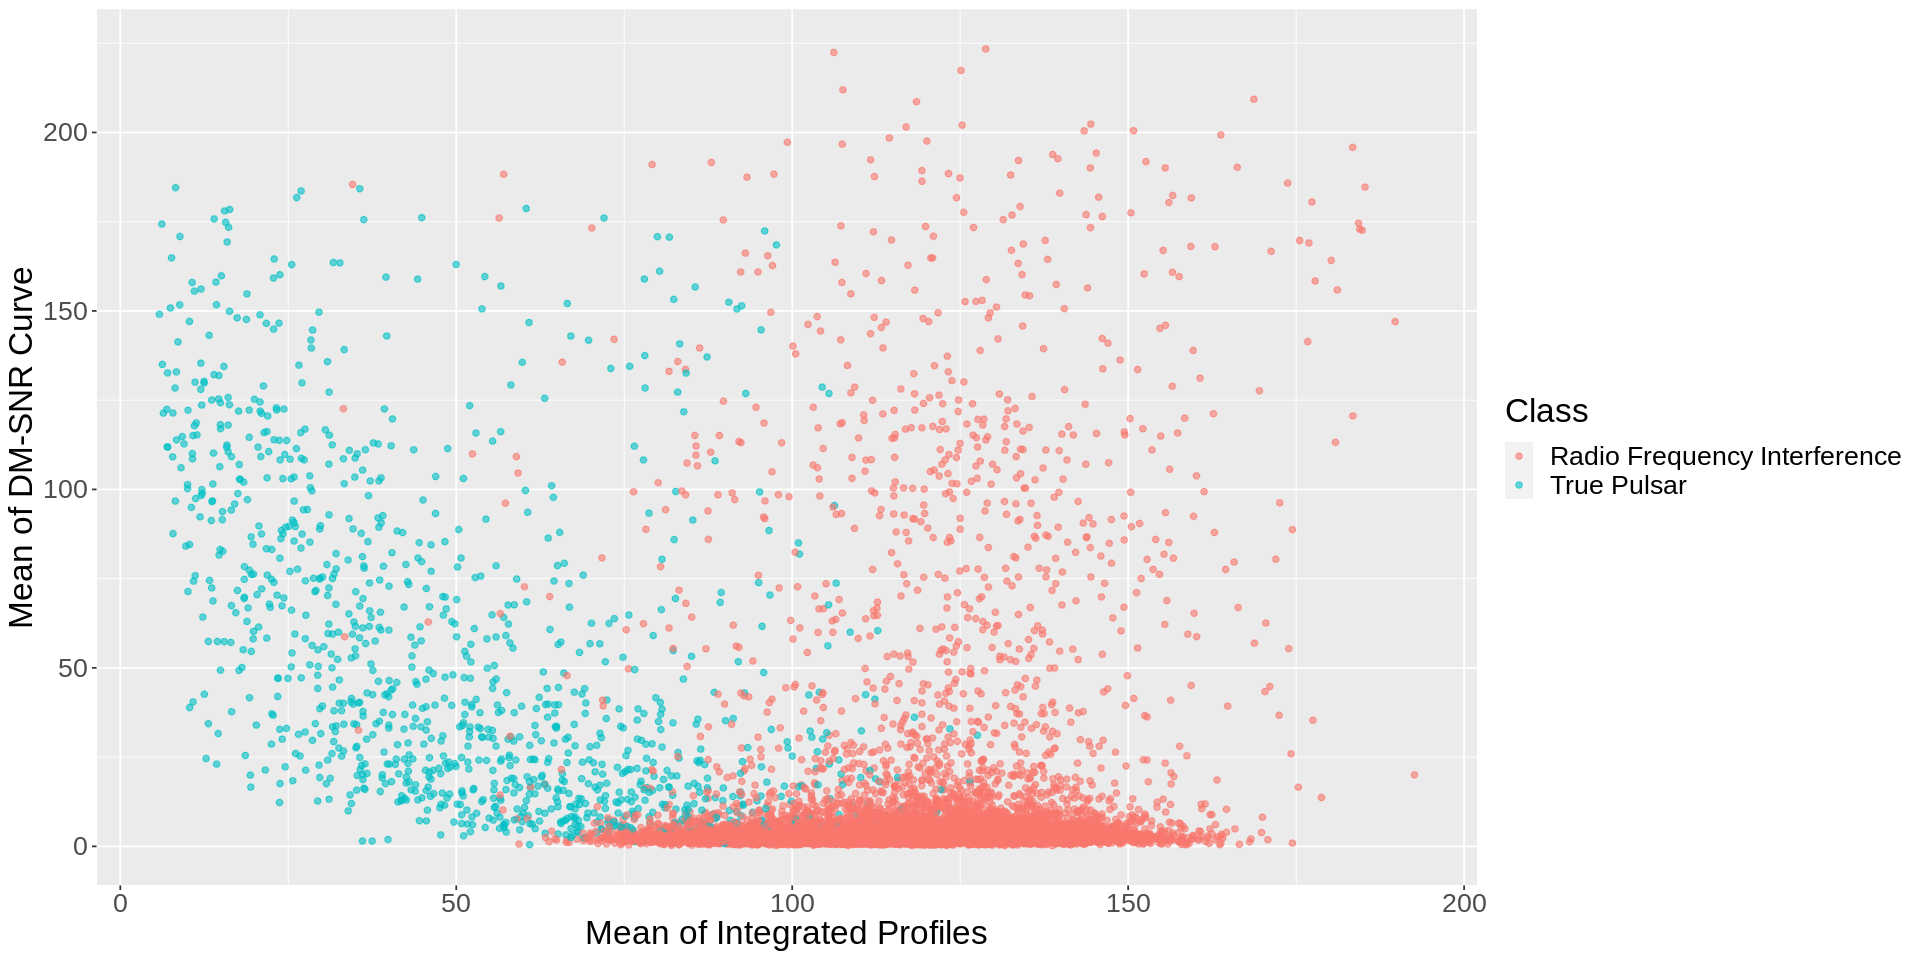

In [7]:
# Next, we will begin some visualization of our training data. We start by building a scatter plot with Mean of Integrated Profiles on the x-axis 
# and Mean of DM-SNR Curve on the y-axis, with True Pulsars labeled by colour. We have started with this graph because it is the most relevant to 
# any k-nearest-neighbour analysis we do in the future.

# DO NOT REMOVE
set.seed(9999) 

# Visualizing the mean of integrated profiles and the mean of DM-SNR curve with colour to differentiate true pulsars
options(repr.plot.width = 16, repr.plot.height = 8)

pulsar_plot <- pulsar_train |>
    ggplot(aes(x = mean_of_int_profiles, y = mean_of_curve)) +
           geom_point(aes(color = true_pulsar), alpha = 0.6) +
           labs(x = "Mean of Integrated Profiles", y = "Mean of DM-SNR Curve", color = "Class")+
           scale_color_discrete(labels=c('Radio Frequency Interference', 'True Pulsar'))+ 
        theme(text = element_text(size = 20))


pulsar_plot

### Methods

#### Data Analysis Strategy and Predictor Variable Selection 

Our classifier will use the K nearest neighbors classification algorithm. We will split the dataset into training and testing sets to evaluate the accuracy of the classifier. Furthermore, we will use the process of cross-validation in order to tune our model and select the most accurate k value. 

For our preliminary data analysis, we chose to use the Mean of Integrated Profiles and the Mean of DM-SNR Curve. We chose these variables because half of the variables described Integrated Profiles and half described the DM-SNR Curve, and we felt that the Mean was the most representative trait from each group. Notice that these choices are only for the preliminary data analysis. Since we have a large amount of data and a relatively small number of variables, we can apply the forward selection model to choose our predictor variables again for the full analysis. 
<br/>

#### Visualization Strategy

We will first visualize our data set using a scatter plot, with the predictor variables on the x and y axes. We will also color the points based on class. This will give us a sense of what patterns we might expect in the data due to the informative nature of visual representation. 

During the process of training our model and choosing a k value,  we will use a line plot in order to help us determine the best k value. This line plot will have accuracy on the x-axis and k on the y-axis and also have points that are connected by the lines.



### Expected Outcomes and Significance

#### Expected Findings
Using our model, we expect to be able to classify any radio frequency as either a pulsar star or radio frequency interference. 
<br/>

#### Impacts
Utilizing computational power to effectively predict whether candidate data is a true pulsar will allow us to efficiently sort and ignore data that we predict to be radio frequency interference. Ultimately, this would optimize pulsar star research, and speed up scientific progress related to pulsar stars, such as space time, the interstellar medium, and states of matter.
<br/>

#### Future Questions
What characteristics tend to differentiate pulsar star frequencies from radio wave frequencies? Could we predict the quantity of a certain variable based on other characteristics that we already know (we would approach this second question with a regression algorithm)? 
